# Multi-modal retrieval using text embedding and CLIP image embedding with `llama-index`

**Credit**: this notebook is adapted from llama-index example: https://docs.llamaindex.ai/en/stable/examples/multi_modal/multi_modal_retrieval/

In this notebook, we will use `chunking` to parse files and directories into chunks, then feed those chunks into `llama-index`'s `MultiModalVectorStoreIndex` for multi-modal retrieval.

## Setup

### Install dependency

In [ ]:
!pip install llama-index-vector-stores-qdrant llama-index-embeddings-huggingface llama-index-embeddings-clip llama-index-llms-ollama
!pip install git+https://github.com/openai/CLIP.git
!pip install matplotlib scikit-image
!pip install qdrant_client
!pip install wikipedia
!pip install "git+https://github.com/chunking-ai/chunking.git@main#egg=chunking-ai[pdf,ocr]"

### Get data

After running the following cells, we will get "./data_wiki" folder that contains images and txt files.

In [1]:
from pathlib import Path
import requests

wiki_titles = [
    "batman",
    "Vincent van Gogh",
    "San Francisco",
    "iPhone",
    "Tesla Model S",
    "BTS",
]


data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

In [3]:
import wikipedia
import urllib.request

image_path = Path("data_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "San Francisco",
    "Batman",
    "Vincent van Gogh",
    "iPhone",
    "Tesla Model S",
    "BTS band",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

San Francisco
Batman
Vincent van Gogh
iPhone
Tesla Model S
BTS band


## Set llama-index LLM and embedding models

In [5]:
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

from llama_index.core import Settings
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.huggingface import HuggingFaceEmbedding


llm = Ollama(model="gemma3:1b-it-qat")
Settings.llm = llm

# loads https://huggingface.co/BAAI/bge-small-en-v1.5
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
Settings.embed_model = embed_model

## Load and chunk data

In [2]:
from chunking import parse

chunks = parse("data_wiki")

2025-05-17 15:36:14,672 - DownloadModel - INFO: /home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/rapid_layout/models/doclayout_yolo_docstructbench_imgsz1024.onnx already exists
2025-05-17 15:36:15,044 - rapid_layout - INFO: doclayout_docstructbench contains ['title', 'plain text', 'abandon', 'figure', 'figure_caption', 'table', 'table_caption', 'table_footnote', 'isolate_formula', 'formula_caption']
2025-05-17 15:36:16,041 - DownloadModel - INFO: /home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/rapid_layout/models/doclayout_yolo_docstructbench_imgsz1024.onnx already exists
2025-05-17 15:36:16,339 - rapid_layout - INFO: doclayout_docstructbench contains ['title', 'plain text', 'abandon', 'figure', 'figure_caption', 'table', 'table_caption', 'table_footnote', 'isolate_formula', 'formula_caption']
2025-05-17 15:36:17,580 - DownloadModel - INFO: /home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/rapid_layout/models/doclayout_yolo_docstructbench

Chunk the data and export to llama-index's node.

In [3]:
from chunking.split.split import FlattenToMarkdown

nodes = []

for chunk in chunks:
    if chunk.mimetype and chunk.mimetype.startswith("image"):
        nodes.append(chunk.to_llamaindex_node())
    elif chunk.mimetype and chunk.mimetype.startswith("text"):
        # Chunk the text
        text_chunks = FlattenToMarkdown.run(chunk, max_size=512)[0]
        nodes.extend([ch.to_llamaindex_node() for ch in text_chunks])

print(f"{len(nodes)=}")

len(nodes)=267


## Build Multi Modal Vector Store

In [4]:
from llama_index.core import StorageContext
import qdrant_client
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="02_qdrant_db")

text_store = QdrantVectorStore(client=client, collection_name="text_collection")
image_store = QdrantVectorStore(client=client, collection_name="image_collection")
storage_context = StorageContext.from_defaults(vector_store=text_store, image_store=image_store)

# Create the MultiModal index
index = MultiModalVectorStoreIndex(nodes, storage_context=storage_context)
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)

## Retrieve and visualize

In [11]:
from pathlib import Path

import matplotlib.pyplot as plt
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if Path(img_path).is_file():
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

### BTS

/home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/llama_index/vector_stores/qdrant/base.py:901: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  response = self._client.search(
/home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/llama_index/vector_stores/qdrant/base.py:901: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  response = self._client.search(


**Node ID:** def6c77baca74efe81339357f50fbce4<br>**Similarity:** 0.7393799930407192<br>**Text:** === Endorsements ===

BTS partnered with Puma beginning in 2015, initially as Puma Korea's brand ambassadors before expanding to global ambassadors in 2018, and promoting the remix of Puma's "Turin...<br>

**Node ID:** 282eebe162204e85817d4499555ec25f<br>**Similarity:** 0.7134534418824311<br>**Text:** BTS (Korean: 방탄소년단; RR: Bangtan Sonyeondan; lit. Bulletproof Boy Scouts), also known as the Bangtan Boys, is a South Korean boy band formed in 2010. The band consists of Jin, Suga, J-Hope, RM, Jimi...<br>

**Node ID:** caa47c13b6ba45bcb11518678141eac2<br>**Similarity:** 0.7068536449853562<br>**Text:** === Fandom ===
According to Kyung Hyun Kim, BTS's rise was facilitated by a great increase in music video programming and consumption on YouTube and the coming of an idol empire, including merchand...<br>

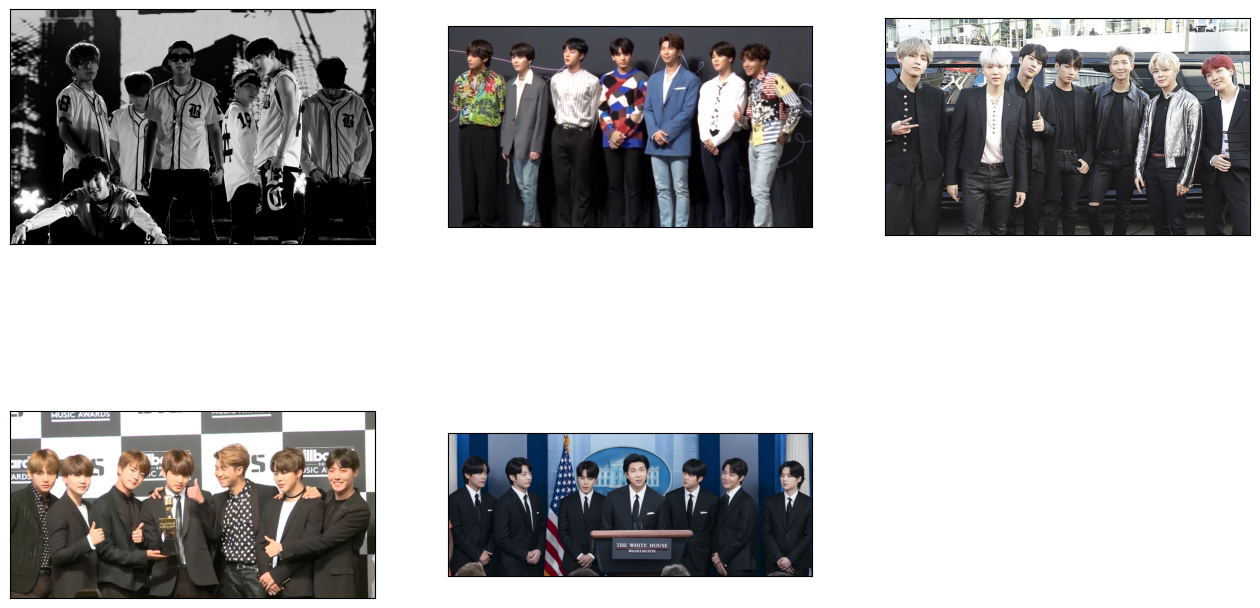

In [12]:
test_query = "who are BTS team members"

retrieval_results = retriever.retrieve(test_query)
retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

### Vincent van Gogh

/home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/llama_index/vector_stores/qdrant/base.py:901: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  response = self._client.search(
/home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/llama_index/vector_stores/qdrant/base.py:901: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  response = self._client.search(


**Node ID:** 13ba0af87c21491284e289550ddd2a7d<br>**Similarity:** 0.8189931181515722<br>**Text:** Van Gogh's work began to attract critical artistic attention in the last year of his life. After his death, his art and life story captured public imagination as an emblem of misunderstood genius, ...<br>

**Node ID:** 2c47fb4a44294489adf32c71e628382b<br>**Similarity:** 0.8102737282934879<br>**Text:** Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪləɱ vɑŋ ˈɣɔx] ; 30 March 1853 – 29 July 1890) was a Dutch Post-Impressionist painter who is among the most famous and influential figures in the history...<br>

**Node ID:** a56e7f20d1824180a2a61d0ffee6513b<br>**Similarity:** 0.7563469666248714<br>**Text:** ==== Portraits ====

Van Gogh said portraiture was his greatest interest. "What I'm most passionate about, much much more than all the rest in my profession", he wrote in 1890, "is the portrait, th...<br>

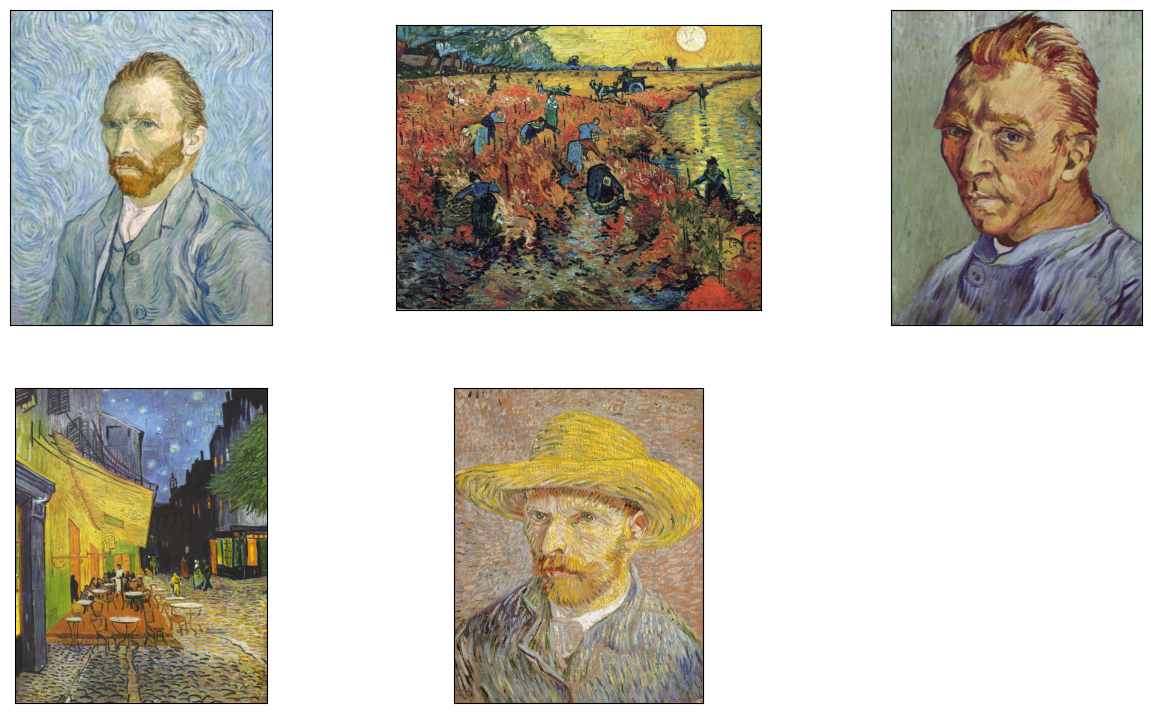

In [13]:
test_query = "what are Vincent van Gogh's famous paintings"

retrieval_results = retriever.retrieve(test_query)
retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

### San Francisco

/home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/llama_index/vector_stores/qdrant/base.py:901: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  response = self._client.search(
/home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/llama_index/vector_stores/qdrant/base.py:901: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  response = self._client.search(


**Node ID:** 3bf0470cfb0441f89f96999ffd124824<br>**Similarity:** 0.7849214505966354<br>**Text:** == Parks and recreation ==

Several of San Francisco's parks and nearly all of its beaches form part of the regional Golden Gate National Recreation Area, one of the most visited units of the Natio...<br>

**Node ID:** de56ce938ebe4134a562ecca483163ef<br>**Similarity:** 0.7623462601680995<br>**Text:** In 2022, San Francisco had more than 1.7 million international visitors and approximately 20 million domestic ones. It is known for its steep rolling hills and eclectic mix of architecture across v...<br>

**Node ID:** d3e9b12b4521445ebdf3a5fc53382253<br>**Similarity:** 0.7521107834543903<br>**Text:** === Technology ===

San Francisco became a hub for technology-driven economic growth during the internet boom of the 1990s, and still holds an important position in the world city network today. In...<br>

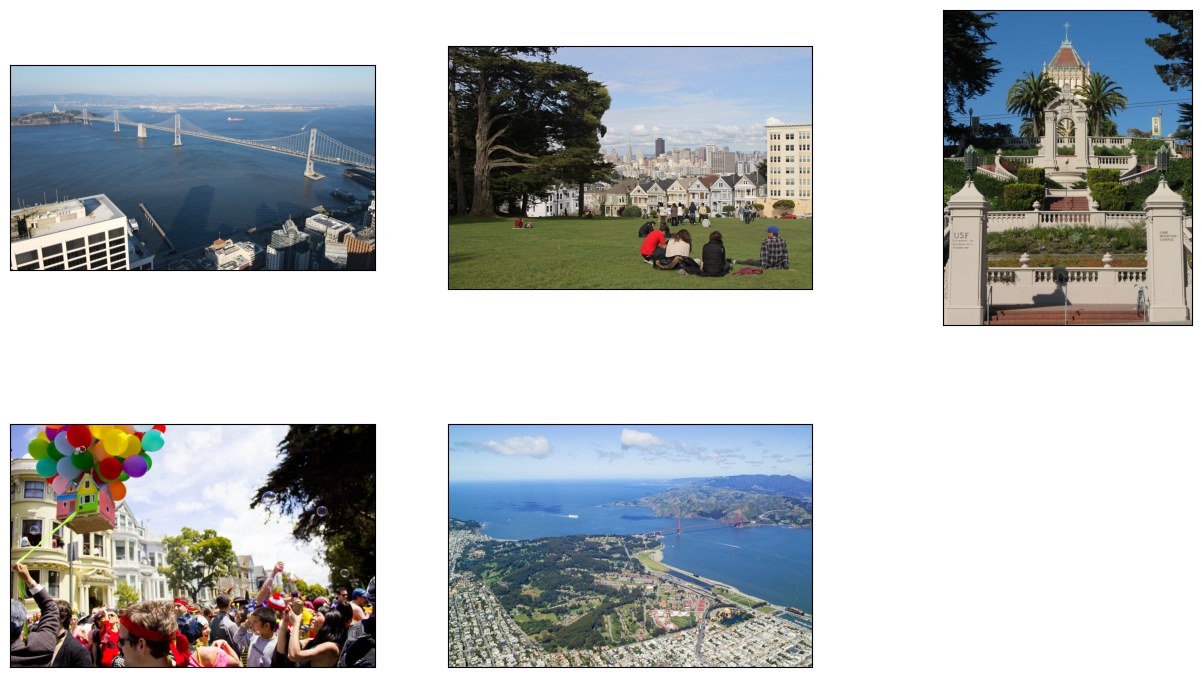

In [14]:
test_query = "what is the popular tourist attraction in San Francisco"

retrieval_results = retriever.retrieve(test_query)
retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

### Tesla

/home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/llama_index/vector_stores/qdrant/base.py:901: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  response = self._client.search(
/home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/llama_index/vector_stores/qdrant/base.py:901: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  response = self._client.search(


**Node ID:** 6aee93d284c2492ca21dfecd2c732297<br>**Similarity:** 0.6903053342989736<br>**Text:** == Development ==
In January 2007, the American automaker Tesla Motors opened a facility in Rochester Hills, Michigan, employing sixty people to work on new projects, including a four-door sedan. B...<br>

**Node ID:** 8f59863316a14ca1bb27ee999a329ef0<br>**Similarity:** 0.6810986745601775<br>**Text:** The Tesla Model S is a battery-electric, four-door full-size car produced by the American automaker Tesla since 2012. The automaker's second vehicle and longest-produced model, the Model S has both...<br>

**Node ID:** 2e120c98852f4ddf8b4b355adc1e0c2d<br>**Similarity:** 0.6768970488304329<br>**Text:** Some companies have developed modified cars based on the Model S with different body styles. In February 2019, a one-off version of the Model S with a shooting brake body style, named the Model SB,...<br>

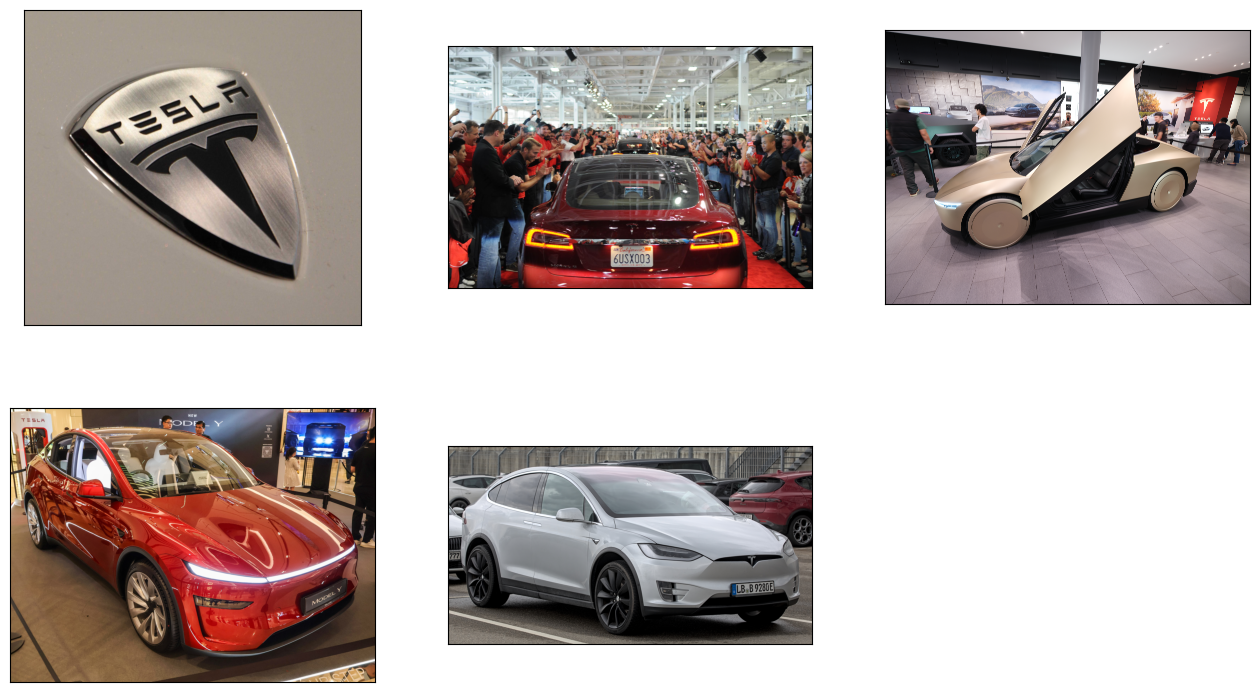

In [15]:
test_query = "which company makes cars"

retrieval_results = retriever.retrieve(test_query)
retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

### Batman

/home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/llama_index/vector_stores/qdrant/base.py:901: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  response = self._client.search(
/home/john/miniconda3/envs/chunkenv/lib/python3.10/site-packages/llama_index/vector_stores/qdrant/base.py:901: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  response = self._client.search(


**Node ID:** 3477ade042fc4117a4b800894b2d0d44<br>**Similarity:** 0.8069236784458612<br>**Text:** ==== Personality ====
Batman's primary character traits can be summarized as "wealth; physical prowess; deductive abilities and obsession". The details and tone of Batman comic books have varied ov...<br>

**Node ID:** 743cae8855f64be6ab0cfd83594bb2ff<br>**Similarity:** 0.7982774372413914<br>**Text:** === Skills and training ===
Batman has no inherent superhuman powers; he relies on "his own scientific knowledge, detective skills, and athletic prowess". Batman's inexhaustible wealth gives him ac...<br>

**Node ID:** 9fee39e83d9246f5a7ea0cdc08881e7e<br>**Similarity:** 0.7888183798931744<br>**Text:** ==== Golden Age ====

In Batman's first appearance in Detective Comics #27, he is already operating as a crime-fighter. Batman's origin is first presented in Detective Comics #33 (November 1939) an...<br>

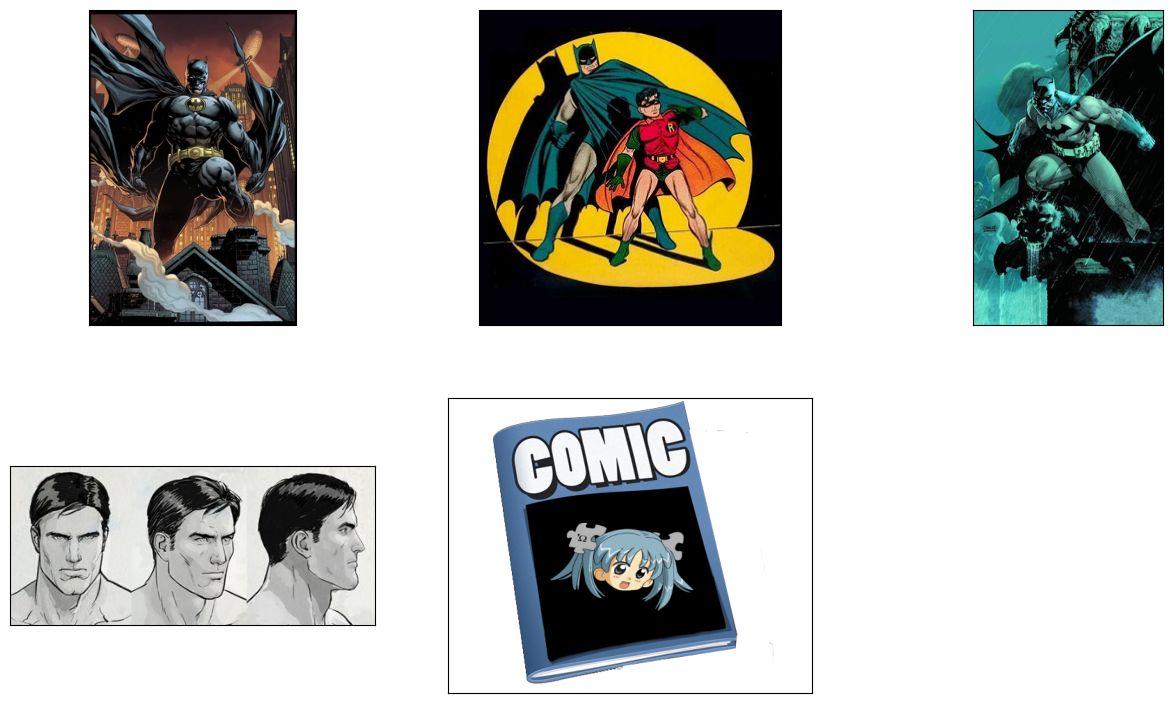

In [16]:
test_query = "what is the main character in Batman"

retrieval_results = retriever.retrieve(test_query)
retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)